Kütüphane yüklerken Tensorflow Addons hatası veriyorsa burayı çalıştır. Hata vermiyorsa çalıştırmaya gerek yok.

In [1]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 4.5 MB/s 


Veri setini kullanmak için öncelikle Dosyalar kısmından ziplenmiş veri setini yükle ardından bu hücredeki kodu çalıştır.

In [2]:
 !unzip Alzheimer_s\ Dataset.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem219.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem22.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem220.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDe

**Kütüphane Yüklemeleri**

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.7.0


**Data Pre-Processing (Veri Ön İşleme)**

In [14]:
base_dir = "Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented']


In [15]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [16]:
#Performing Image Augmentation to have more data samples
# Daha fazla veri örneğine sahip olmak için Image Augmentation gerçekleştirme

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(preprocessing_function=preprocess_input, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


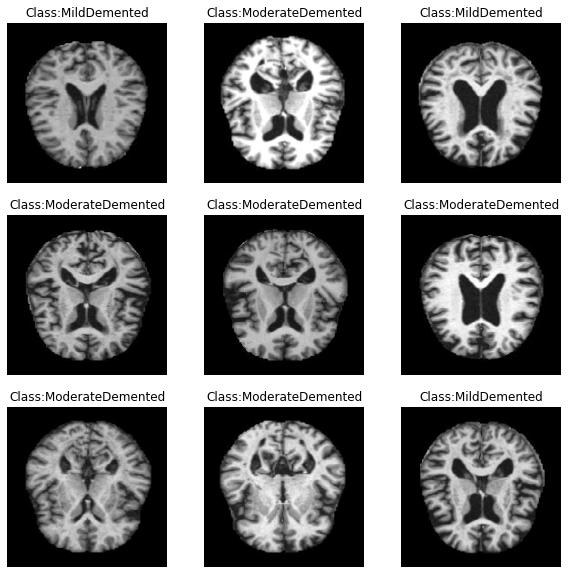

In [ ]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

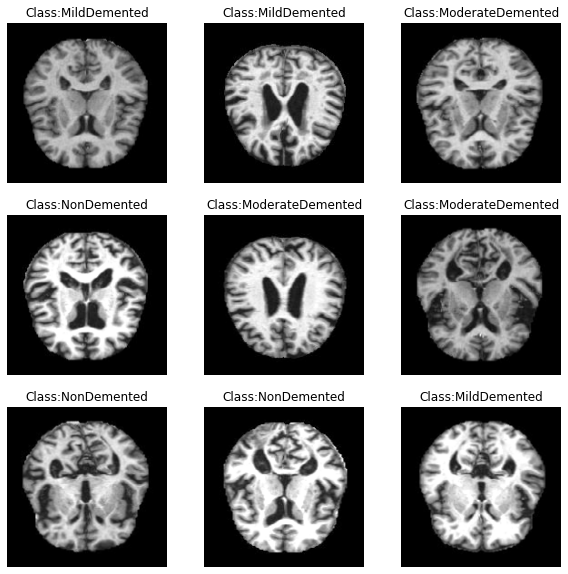

In [ ]:
show_images(train_data_gen)

Yukarıdaki kısımlarda verileri sınıflandırmış. Verilerin görselleştirildiği kısımları çalıştırmaya gerek yok, çalıştırınca 12 GB ram doluyor ve diğer işlemleri yapamıyorsun.

In [17]:
#Retrieving the data from the ImageDataGenerator iterator 
#ImageDataGenerator iterator üzerinden veri alma

train_data, train_labels = train_data_gen.next()

In [8]:
#Getting to know the dimensions of our dataset
#Veri setimizdeki boyutları öğrenme

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [18]:
#Splitting the data into train, test, and validation sets
#Veriyi train, test ve validation olarak ayıralım

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

**ResNet50**

In [19]:
resnet_model = ResNet50(input_shape=(176, 176, 3), include_top=False, weights="imagenet")


In [20]:
for layer in resnet_model.layers:
    layer.trainable=False

In [25]:
custom_resnet_model = Sequential([
        resnet_model,
        Dropout(0.5),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "resnet_cnn_model")

In [26]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [27]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback, rop_callback]
    
custom_resnet_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_resnet_model.summary()

Model: "resnet_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 dropout_10 (Dropout)        (None, 6, 6, 2048)        0         
                                                                 
 flatten_2 (Flatten)         (None, 73728)             0         
                                                                 
 batch_normalization_12 (Bat  (None, 73728)            294912    
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 512)               37749248  
                                                                 
 batch_normalization_13 (Bat  (None, 512)              2048      
 chNormalization)                                 

**Training & Testing the Model (Modeli Eğitelim ve Test Edelim)**




In [28]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 100

history = custom_resnet_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/100
128/128 [==============================] - 38s 256ms/step - loss: 1.4173 - acc: 0.3931 - auc: 0.6528 - f1_score: 0.2786 - val_loss: 1.1101 - val_acc: 0.5518 - val_auc: 0.7963 - val_f1_score: 0.2740 - lr: 0.0010
Epoch 2/100
128/128 [==============================] - 29s 225ms/step - loss: 1.0955 - acc: 0.5095 - auc: 0.7837 - f1_score: 0.3050 - val_loss: 0.9543 - val_acc: 0.5703 - val_auc: 0.8380 - val_f1_score: 0.3027 - lr: 0.0010
Epoch 3/100
128/128 [==============================] - 29s 224ms/step - loss: 0.9765 - acc: 0.5479 - auc: 0.8258 - f1_score: 0.3216 - val_loss: 0.9274 - val_acc: 0.5957 - val_auc: 0.8525 - val_f1_score: 0.3095 - lr: 0.0010
Epoch 4/100
128/128 [==============================] - 29s 223ms/step - loss: 0.9006 - acc: 0.5906 - auc: 0.8519 - f1_score: 0.3636 - val_loss: 0.9480 - val_acc: 0.5859 - val_auc: 0.8541 - val_f1_score: 0.3220 - lr: 0.0010
Epoch 5/100
128/128 [==============================] - 29s 224ms/step - loss: 0.8194 - acc: 0.6418 - auc: 0.

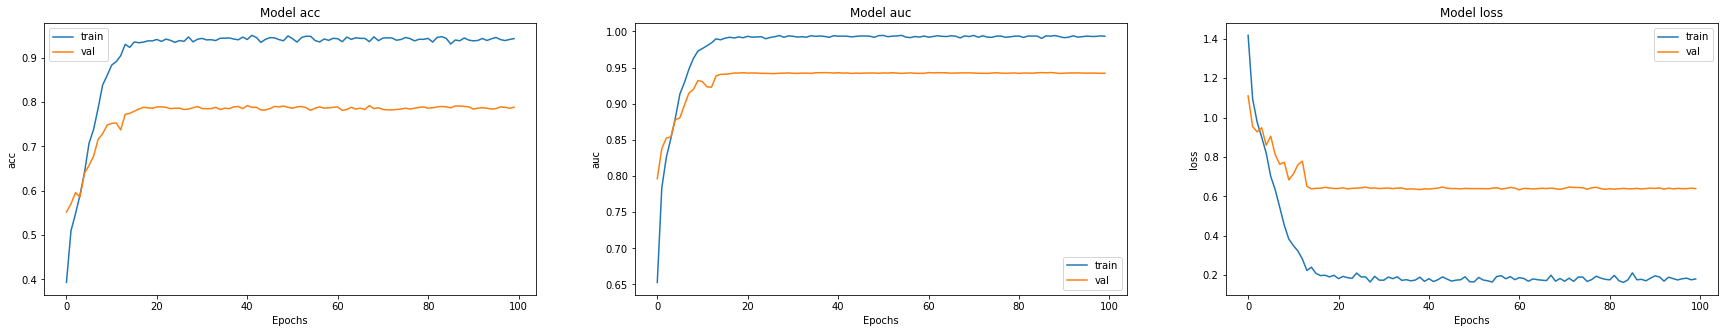

In [29]:
#Plotting the trend of the metrics during training
#Eğitim sırasındaki metriklerin (accuracy, auc, loss) eğilimlerini çizme

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [30]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = custom_resnet_model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

40/40 [==============================] - 6s 152ms/step - loss: 0.6819 - acc: 0.7820 - auc: 0.9414 - f1_score: 0.5662
Testing Accuracy: 78.20%


In [31]:
#Predicting the test data

pred_labels = custom_resnet_model.predict(test_data)

In [32]:
#Saving the model for future use

custom_resnet_model_dir = work_dir + "alzheimer_resnet_model"
custom_resnet_model.save(custom_resnet_model_dir, save_format='h5')
os.listdir(work_dir)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


['VeryMildDemented',
 'alzheimer_resnet_model',
 'ModerateDemented',
 'MildDemented',
 'NonDemented']

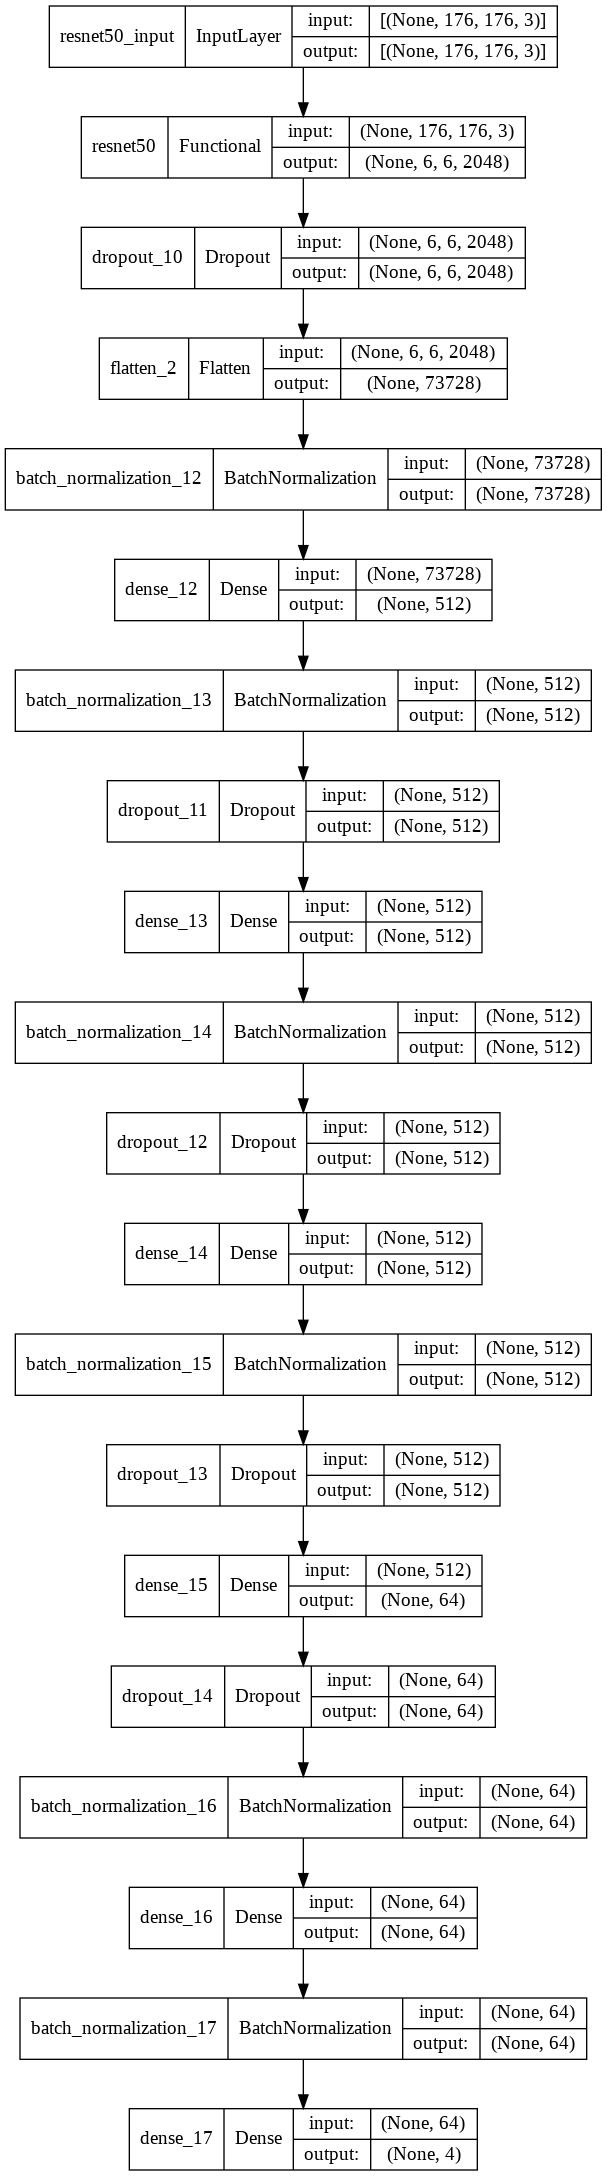

In [33]:
pretrained_model = tf.keras.models.load_model(custom_resnet_model_dir)

#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)